In [2]:
import numpy as np
from scipy.stats import poisson
import time
from collections import deque
import matplotlib.pyplot as plt

In [3]:
class AdEventMonitor:
    def __init__(self, window_size=100, confidence_level=0.95):
        self.window_size = window_size
        self.confidence_level = confidence_level
        
        # Separate windows for clicks and impressions
        self.click_window = deque(maxlen=window_size)
        self.impression_window = deque(maxlen=window_size)
        
        # Initial lambda estimates
        self.click_lambda = 5.0  # starting estimate
        self.impression_lambda = 100.0  # starting estimate
        
        # Track anomalies
        self.click_anomalies = []
        self.impression_anomalies = []
        
    def update_lambda(self, window, current_lambda):
        """Update lambda using exponential moving average"""
        if len(window) > 0:
            new_lambda = np.mean(window)
            return 0.9 * current_lambda + 0.1 * new_lambda
        return current_lambda
    
    def is_anomaly(self, value, expected_lambda):
        """Check if value is anomalous given current lambda"""
        lower_bound = poisson.ppf((1 - self.confidence_level) / 2, expected_lambda)
        upper_bound = poisson.ppf((1 + self.confidence_level) / 2, expected_lambda)
        return value < lower_bound or value > upper_bound
    
    def process_event(self, clicks, impressions, timestamp):
        """Process new event data"""
        # Add to windows
        self.click_window.append(clicks)
        self.impression_window.append(impressions)
        
        # Update lambda estimates
        self.click_lambda = self.update_lambda(self.click_window, self.click_lambda)
        self.impression_lambda = self.update_lambda(self.impression_window, self.impression_lambda)
        
        # Check for anomalies
        if self.is_anomaly(clicks, self.click_lambda):
            self.click_anomalies.append((timestamp, clicks))
            print(f"Click Anomaly detected at {timestamp}: {clicks} (expected around {self.click_lambda:.2f})")
            
        if self.is_anomaly(impressions, self.impression_lambda):
            self.impression_anomalies.append((timestamp, impressions))
            print(f"Impression Anomaly detected at {timestamp}: {impressions} (expected around {self.impression_lambda:.2f})")
        
        return {
            'timestamp': timestamp,
            'clicks': clicks,
            'impressions': impressions,
            'click_lambda': self.click_lambda,
            'impression_lambda': self.impression_lambda,
            'click_anomaly': self.is_anomaly(clicks, self.click_lambda),
            'impression_anomaly': self.is_anomaly(impressions, self.impression_lambda)
        }

In [4]:
def simulate_ad_events(duration_seconds=60, anomaly_probability=0.1):
    """Simulate streaming ad events with occasional anomalies"""
    monitor = AdEventMonitor()
    results = []
    
    base_click_rate = 5
    base_impression_rate = 100
    
    start_time = time.time()
    current_time = start_time
    
    while current_time - start_time < duration_seconds:
        # Simulate normal traffic
        if np.random.random() > anomaly_probability:
            clicks = np.random.poisson(base_click_rate)
            impressions = np.random.poisson(base_impression_rate)
        else:
            # Simulate anomaly (sudden spike or drop)
            multiplier = np.random.choice([0.2, 5.0])  # Either drop or spike
            clicks = np.random.poisson(base_click_rate * multiplier)
            impressions = np.random.poisson(base_impression_rate * multiplier)
        
        # Process event
        result = monitor.process_event(clicks, impressions, current_time)
        results.append(result)
        
        # Simulate time passing
        time.sleep(1)
        current_time = time.time()
    
    return results

In [5]:
def plot_results(results):
    """Plot the results of the simulation"""
    timestamps = [r['timestamp'] - results[0]['timestamp'] for r in results]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot clicks
    ax1.plot(timestamps, [r['clicks'] for r in results], 'b.', label='Actual Clicks')
    ax1.plot(timestamps, [r['click_lambda'] for r in results], 'r-', label='Expected Clicks (λ)')
    ax1.scatter([t for t, _ in monitor.click_anomalies],
                [c for _, c in monitor.click_anomalies],
                color='red', marker='x', s=100, label='Anomalies')
    ax1.set_title('Click Traffic Over Time')
    ax1.set_ylabel('Clicks')
    ax1.legend()
    
    # Plot impressions
    ax2.plot(timestamps, [r['impressions'] for r in results], 'g.', label='Actual Impressions')
    ax2.plot(timestamps, [r['impression_lambda'] for r in results], 'r-', label='Expected Impressions (λ)')
    ax2.scatter([t for t, _ in monitor.impression_anomalies],
                [i for _, i in monitor.impression_anomalies],
                color='red', marker='x', s=100, label='Anomalies')
    ax2.set_title('Impression Traffic Over Time')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Impressions')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

Impression Anomaly detected at 1734672084.4537554: 16 (expected around 98.91)
Click Anomaly detected at 1734672090.4632432: 27 (expected around 5.13)
Impression Anomaly detected at 1734672090.4632432: 539 (expected around 99.30)
Impression Anomaly detected at 1734672091.4651952: 81 (expected around 101.46)
Impression Anomaly detected at 1734672098.4760835: 74 (expected around 109.62)
Click Anomaly detected at 1734672099.4779718: 26 (expected around 5.63)
Impression Anomaly detected at 1734672099.4779718: 497 (expected around 111.73)
Click Anomaly detected at 1734672104.4859505: 23 (expected around 5.94)
Impression Anomaly detected at 1734672104.4859505: 488 (expected around 119.31)
Impression Anomaly detected at 1734672105.4877174: 90 (expected around 121.08)
Impression Anomaly detected at 1734672106.4895535: 96 (expected around 122.54)
Impression Anomaly detected at 1734672107.4912555: 99 (expected around 123.74)
Impression Anomaly detected at 1734672108.4931383: 97 (expected around 1

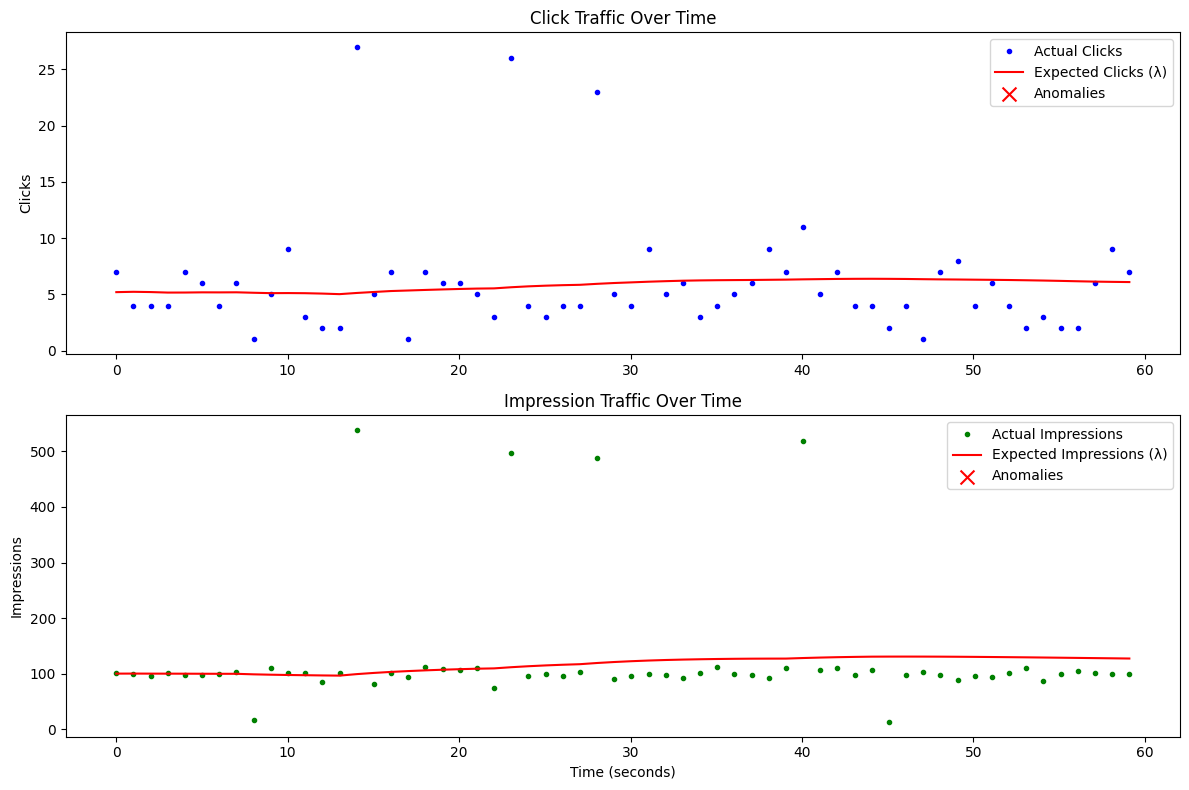

In [6]:
monitor = AdEventMonitor()
results = simulate_ad_events(duration_seconds=60)
plot_results(results)